In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Data_train.csv')

In [3]:
data.head(5)

,CLIENTE,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X79,X80,X81,X82,X83,X84,X85,X86,X87,y
0,C_26572,2,3,3,15.652542,8.294133,7.358409,10.203390,3,4,...,0,No,No,No,951,79,872,89.0,10.0,0
1,C_47823,1,1,1,6.779661,1.288000,5.491661,6.779661,1,2,...,1,No,No,No,628,54,574,628.0,574.0,1
2,C_28925,7,49,51,319.355932,120.441150,198.914782,233.584746,4,7,...,1,No,No,No,969,9,960,35.0,26.0,0
3,C_74142,12,68,86,3153.338983,2171.714952,981.624031,1633.932203,14,90,...,1,No,Si,No,968,5,963,8.0,3.0,0
4,C_32527,12,39,41,370.423729,163.928936,206.494793,270.118644,3,41,...,0,No,Si,No,943,4,939,6.0,2.0,0


In [4]:
print(f'Cantidad de observaciones: {data.shape[0]}')
print(f'Cantidad de columnas: {data.shape[1]}')

Cantidad de observaciones: 57631
Cantidad de columnas: 90


In [5]:
print('Cantidad de variables númericas : {} '.format(data.select_dtypes(['int64','float64']).shape[1]))
print('Cantidad de variables object : {} '.format(data.select_dtypes(['object']).shape[1]))

Cantidad de variables númericas : 85 
Cantidad de variables object : 5 


- Existen missing values?

In [6]:
data.isna().sum().sort_values(ascending = False).to_frame()[0:10].rename(columns = {0:"Cantidad de missings"})

,Cantidad de missings
X18,16426
X19,14989
X21,10585
X78,4522
X6,2374
X87,1287
X86,1287
X10,3
X73,1
CLIENTE,0


- Existe 9 variables con missing values. Hay que conocer cuanto equivale esos missings values en relación al total de observaciones

In [7]:
pd.options.display.float_format = "{:,.2f}".format
data.isna().sum().sort_values(ascending = False).to_frame()[0:10].rename(columns = {0:"Porcentaje(%) de missings"})/data.shape[0]*100

,Porcentaje(%) de missings
X18,28.50
X19,26.01
X21,18.37
X78,7.85
X6,4.12
X87,2.23
X86,2.23
X10,0.01
X73,0.00
CLIENTE,0.00


- La variable X18, es la que tiene mayor cantidad de nulos llegan a cubrir el 28.5% del total de observaciones, seguida de la variable X19, con 26.01%
- Podemos ver que ante los elevados porcentajes de missings, eliminaremos las variables X18, X19 y X21, ya que el imputarlas puede generar cambios en su distribución y sesgos más adelante en el análisis.
- Ahora es necesario saber si estás variables con missings values son de tipo numéricas o de clasificación

In [8]:
data.drop(columns = ['X18', 'X19', 'X21'], axis= 1,inplace = True)

In [9]:
data.isna().sum().sort_values(ascending = False)[0:5].index

Index(['X78', 'X6', 'X87', 'X86', 'X10'], dtype='object')

## Imputación de missings
En el caso de clientes, los outliers no los eliminaremos ya que al no conocer el nombre de las variables, el eliminar valores podría hacernos perder información de clientes además de que se estandarizará los datos posteriormente.
\
Variables de imputar:
- X78
- X6
- X87
- X86
- X10

In [10]:
def distri(col):
    media = data[col].mean().round(2)
    mediana = data[col].median()
    maximo = data[col].max()
    iqr = 1.5 * (np.percentile(data[col], 75) - np.percentile(data[col], 25))
    upper = iqr + np.percentile(data[col], 75)
    lower = np.percentile(data[col], 25).round(0) - iqr
    minimo = data[col].min()
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(x =data[col], ax=ax_box)
    sns.histplot(data[col], ax=ax_hist, kde = True)
    ax_hist.axvline(x=media, color='b', linestyle='--', label='Media:{}'.format(media))
    ax_hist.axvline(x=mediana, color='g', linestyle='-.', label='Mediana:{}'.format(mediana))
    #plt.axvline(x=lower, color='yellow', linestyle='-', label='Lower IQR:{}'.format(lower))
    #plt.axvline(x=upper, color='yellow', linestyle='-', label='UpperIQR:{}'.format(upper))
    plt.legend()

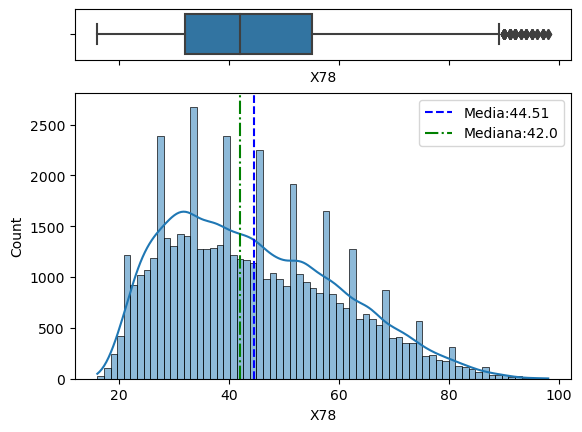

In [11]:
#X78
distri('X78')

- El promedio y la mediana se encuentran muy cerca lo cual es favorable. No imputaremos con la media o la mediana, si no con una muestra de la variable para no cambiar la distribución de la variable
- Los outliers no conocemos su origen, de que si son un error en la carga de la data o si es un comportamiento real de los usuariros. Por ese motivo no los trataré en esta oportunidad.

In [12]:
def resample_fillna(col):
        # get series consisting of non-NaN values
        valid_series = data[col].dropna()
        nan_indices = data.loc[data[col].isna()][col].index
        for nan_index in nan_indices:
            data[col][nan_index] = valid_series.sample(n=1)

In [13]:
for i in ['X78', 'X6', 'X87', 'X86', 'X10','X73']:
    resample_fillna(i)

In [14]:
data.isna().sum().sort_values(ascending = False).to_frame()[0:10].rename(columns = {0:"Cantidad de missings"})

,Cantidad de missings
CLIENTE,0
X57,0
X65,0
X64,0
X63,0
X62,0
X61,0
X60,0
X59,0
X58,0


- Nos encargamos de los missings values

## Análisis exploratorio

In [15]:
data.describe(include =['float64','int64'])

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X76,X77,X78,X79,X83,X84,X85,X86,X87,y
count,"57,631.00","57,631.00","57,631.00","57,631.00","57,631.00","57,631.00","57,631.00","57,631.00","57,631.00","57,631.00",...,"57,631.00","57,631.00","57,631.00","57,631.00","57,631.00","57,631.00","57,631.00","57,631.00","57,631.00","57,631.00"
mean,6.67,16.35,18.94,508.32,368.91,139.41,224.36,5.48,21.05,4.20,...,2.80,15.88,44.48,0.44,807.25,25.87,781.39,85.12,59.43,0.04
std,3.48,19.45,26.05,"1,789.76","1,900.25",336.13,402.91,4.52,23.16,4.99,...,7.65,22.98,15.45,0.50,243.84,24.25,248.60,115.26,107.65,0.19
min,1.00,1.00,1.00,0.00,0.00,"-50,594.19",-20.90,1.00,1.00,0.00,...,0.00,0.00,16.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00
25%,4.00,5.00,5.00,79.35,44.78,22.40,37.42,2.00,7.00,1.00,...,0.00,4.00,32.00,0.00,765.00,6.00,734.00,21.00,7.00,0.00
50%,7.00,10.00,11.00,213.32,132.22,66.88,103.25,4.00,14.00,3.00,...,0.00,9.00,42.00,0.00,925.00,18.00,892.00,47.00,20.00,0.00
75%,10.00,21.00,23.00,539.84,358.59,164.03,251.22,7.00,27.00,5.00,...,2.00,19.00,55.00,1.00,961.00,40.00,941.00,99.00,60.00,0.00
max,12.00,352.00,"1,370.00","354,363.98","404,958.16","11,445.04","16,820.93",56.00,912.00,74.00,...,244.00,"1,062.00",98.00,1.00,972.00,91.00,972.00,972.00,959.00,1.00


In [17]:
data.describe(include =['object'])

,CLIENTE,X73,X80,X81,X82
count,57631,57631,57631,57631,57631
unique,57631,3,2,2,2
top,C_26572,N,No,No,No
freq,1,36106,50383,44884,57468


In [ ]:
for i in data.select_dtypes(['int64','float64']).T.index.to_list():
    distri(i)

KeyboardInterrupt: 